# Poison Mushroom Random Forest Classifier

## Overview

In this project I implement a random forest classifier on a well-formatted open source dataset. Each entry contains categorical variables about a particular mushroom and a class label marking it as poisonous (label value of 1) or edible (label value of -1). The dataset can be downloaded from [this link](https://www.openml.org/d/24) which contains a summary of the feature space.
   
In the first part I implement the hyperparameter search and model selection. Model selection involves choosing the tree depth and whether or not to use AdaBoost during training. AdaBoost is an iterative algorithm that determines weights for training points that minimizes training error over an exponential loss function (see subsection below for details). The hyperparameters of this classifier are number of folds in cross validation, ensemble size, feature set random sample size, training set bootstrap sample size and in the case of boosted models, number of boosting iterations. To save computing time, I train boosted models on a subset of the hyperparamaters chosen based on nominal model performance. I conclude the section by analyzing the relationship between validation error and hyperparameters / model choice to determine which models and hyperparameters to use on the test set. In the second part I analyze the performance of a medium-depth nominal and boosted model on the test set to infer classifier performance on the greater mushroom population.

In both sections, a random forest is represented as a list of decision trees and each decision tree is trained on a simple random sample of features from a bootstrap sample of the training set. Predictions are obtained by averaging the prediction of every decision tree on the validation / test set and comparing the averaged prediction to a passed in classification threshold which takes a value in the range [-1, 1] (0 by default).

#### AdaBoost Overview

Below is the pseudocode of the AdaBoost algorithm on a dataset $\{(x_{i}, y_{i})\}^{n}_{i = 1}$ where $x_{i}$ in $R^{d}$ and $y_{i}$ in $\{-1, 1\}$.

1) Initialize $w_{i} = \frac{1}{n}$ (nominal weights) for all n training points.

2) For $m$ in $\{1, 2, ..., M\}$: <br> **a)** Train a classifier $F_{m}$ according to weights $\{w_{i}\}^{n}_{i=1}$
    <br> **b)** Compute weighted error $e_{m} = \sum_{misclassified-training-points} w_{i}$
    <br> **c)** Reweigh training points as: $w_{i} = w_{i}\cdot\begin{cases} 
                                                            \sqrt{\frac{1-e_{m}}{e_{m}}} & if misclassified\\
                                                            \sqrt{\frac{e_{m}}{1-e_{m}}} & otherwise
                                                            \end{cases}$
    <br> **d)** Normalize weights to sum to 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Read and clean data, transform class labels and obtain schema
mushroom_set = pd.read_csv('dataset_mushroom.csv')
mushroom_set.rename(columns = {'bruises%3F': 'bruises'}, inplace = True)
mushroom_set['class'] = mushroom_set['class'].map({"'p'": 1, "'e'": -1})
features = list(mushroom_set.columns)[0:22]
n, d = len(mushroom_set), len(features)
print('Dataset size: ', n)
print('Number of features: ', d)
mushroom_set.head()

Dataset size:  8124
Number of features:  22


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,'x','s','n','t','p','f','c','n','k','e',...,'w','w','p','w','o','p','k','s','u',1
1,'x','s','y','t','a','f','c','b','k','e',...,'w','w','p','w','o','p','n','n','g',-1
2,'b','s','w','t','l','f','c','b','n','e',...,'w','w','p','w','o','p','n','n','m',-1
3,'x','y','w','t','p','f','c','n','n','e',...,'w','w','p','w','o','p','k','s','u',1
4,'x','s','g','f','n','f','w','b','k','t',...,'w','w','p','w','o','e','n','a','g',-1


In [2]:
# Obtain numerical training and test set from categorical dataset
X_train, X_test, Y_train, Y_test = train_test_split(pd.get_dummies(mushroom_set[features]), mushroom_set['class'], test_size = 0.1, random_state = 42)

In [3]:
def make_and_train_decision_tree(training_set, labels, depth, train_weights = None):
    # Returns decision tree trained according to greedy mutual information maximization 
    # over possible (feature,value)-split pairs in that set. I use min_samples_leaf parameter as a means 
    # of tuning tree depth.
    depths = {'shallow': 125, 'medium': 75, 'deep': 25}
    tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = depths[depth])
    tree.fit(training_set, labels, sample_weight = train_weights)
    return tree

def make_and_train_random_forest(training_set, labels, ens_size, m, k, depth):
    # Trains and returns random forest (as list of decision tree classifiers) of length ens_size.
    # Training set and feature samples of each random forest (size m & k respectively) are taken
    # as bootstrap samples from the passed in training_set.
    forest = []
    n,d = training_set.shape
    for j in range(ens_size):
        feat_indx = list(np.random.choice(range(d), size = k, replace = False))
        train_indx = list(np.random.choice(range(n), size = m, replace = True))
        tree = make_and_train_decision_tree(training_set.iloc[train_indx, feat_indx], labels.iloc[train_indx], depth)
        forest.append({'tree': tree, 'feats': feat_indx})
    return forest

In [4]:
def make_and_train_boosted_random_forest(training_set, training_labels, ens_size, m, k, M, depth):
    # Same functionality as make_and_train_random_forest except that for each decision tree training points
    # are weighed as determined by M iterations of AdaBoost.
    forest = []
    n,d = training_set.shape
    for j in range(ens_size):
        feat_indx = list(np.random.choice(range(d), size = k, replace = False))
        train_indx = list(np.random.choice(range(n), size = m, replace = True))
        
        sample_weight = np.array([1/len(train_indx) for q in range(len(train_indx))])
        
        # Perform M iterations of AdaBoost
        for i in range(M):
            tree = make_and_train_decision_tree(training_set.iloc[train_indx, feat_indx], training_labels.iloc[train_indx], 
                                                depth, train_weights = sample_weight)
            
            predicted_labels = evaluate_decision_tree(tree, training_set.iloc[train_indx, feat_indx])
            error_indicators = get_error_indicators(predicted_labels, training_labels.iloc[train_indx])
            weighted_error = error_indicators @ sample_weight
            adjust_factor = np.sqrt((1-weighted_error)/weighted_error)
            
            sample_weight = np.array([w*adjust_factor if i == 1 else w/adjust_factor for (w, i) in zip(sample_weight, error_indicators)])
            
            weight_sum = sum(sample_weight)
            sample_weight = np.array([w/weight_sum for w in sample_weight])
            
        forest.append({'tree': tree, 'feats': feat_indx})

    return forest

In [5]:
def evaluate_decision_tree(decision_tree, validation_set):
    # Returns decision_tree prediction for every member of validation_set
    return decision_tree.predict(validation_set)

def get_error_indicators(prediction, true_labels):
    # Returns list of indicators of error in prediction for each element of validation set.
    return np.array([0 if x == y else 1 for (x, y) in zip(prediction, true_labels)])

def evaluate_random_forest(forest, validation_set, labels, weights = None, threshold = 0):
    # Takes in trained random forest and validation set and returns validation error, predicted labels and true labels
    # according to given classification threshold. Ensemble prediction is computed by the average of its members predictions 
    # unless weights are manually passed in.
    assert np.abs(threshold) <= 1
    
    if weights is None:
        tree_weights = np.array([1/len(forest) for tree in forest])
    else:
        tree_weights = weights
    
    forest_predictions = []
    for dic in forest:
        predict = evaluate_decision_tree(dic['tree'], validation_set.iloc[:,dic['feats']])
        forest_predictions.append(predict)
    
    prediction = []
    for j in range(len(labels)):
        predictions_by_tree = np.array([forest_predictions[i][j] for i in range(len(forest_predictions))])
        pred_class = np.sign((predictions_by_tree @ tree_weights)-threshold)
        if pred_class == 0.0:
            prediction.append(1.0)
        else:
            prediction.append(pred_class)
    prediction = np.array(prediction)

    indicators = get_error_indicators(prediction, labels)
    
    return sum(indicators) / len(indicators), pd.DataFrame(np.array([prediction, labels]).T, columns = ['predicted', 'true'])

## Hyperparameter Search & Model Selection

In this section I find the validation error of all model-hyperparameter configurations. The following hyperparameters comprise the search space: number of folds in cross validation (**f**), ensemble size (**ens_size**), feature sample size (**k**), training set sample size (**m**), and in the case of boosted models, number of boosting iterations (**M**). 

I analyze the relationship of validation error over different model choices and various functions of hyperparameters in order to select a model and hyperparameters to use on the test set. Further, I compare the robustness (sensitivity of validation error to various hyperparameters) of boosted and nominal models.

In [6]:
def train_and_validate(training_set, training_labels, validation_set, validation_labels, ens_size, m, k, depth, boosting = False, M = None):
    # Trains and validates random forest with specified data, ensemble size,training set sample size and feature sample size.
    # Returns validation error.
    global n, d
    assert m <= n
    assert k <= d
    assert boosting ^ (M is None)
    
    if boosting:
        forest = make_and_train_boosted_random_forest(training_set, training_labels, ens_size, m, k, M, depth)
    else:
        forest = make_and_train_random_forest(training_set, training_labels, ens_size, m, k, depth)

    validation_error, _ = evaluate_random_forest(forest, validation_set, validation_labels)
    
    
    return validation_error

In [7]:
def cross_validate(data_set, labels, size, k, f, m, depth, boosting = False, M = None):
    # Performs f-fold cross validation on data_set for hyperparameters ensemble size (size), feature sample size (k), 
    # training sample size (m) and if using boosted forests, boosting iterations (M).
    # Returns training and validation error.
    validation_errors = []
    
    n = len(data_set)
                    
    for i in range(f):
        v_indx = [j for j in range(i*n//f, (i+1)*n//f)]
        t_indx = [j for j in range(0, i*n//f)] + [j for j in range((i+1)*n//f, n)]
                        
        validation_set = data_set.iloc[v_indx,:]
        validation_labels = labels.iloc[v_indx]
        training_set = data_set.iloc[t_indx,:]
        training_labels = labels.iloc[t_indx]
                        
        validation_error= train_and_validate(training_set, training_labels, validation_set, 
                                                            validation_labels, size, m, k, depth, boosting, M)
        validation_errors.append(validation_error)
                    
    avg_validation_error = sum(validation_errors) / len(validation_errors)
    
    return avg_validation_error

In [8]:
def tune_hyperparameters(ensemble_sizes, feature_sample_sizes, folds, depth, boosting = False):
    # Tunes the following hyperparameters using k-fold
    # cross validation with k taking on values in folds: ensemble size
    #                                                    feature sample size
    #                                                    training set sample size
    #
    # Returns optimal paramaters and validation error of model under every hyperparameter configuration
    global X_train, Y_train, n
    
    min_err = np.inf
    
    results = []
    
    # Cross-validate for every possible hyperparameter configuration
    for size in ensemble_sizes:
        for k in feature_sample_sizes:
            for f in folds:
                
                # Define training set sample size search space
                m_max = n - n//f
                training_set_sample_sizes = np.arange(m_max//5, m_max, step = m_max//4)
                
                for m in training_set_sample_sizes:
                    if boosting:
                        # Define boosting iteration search space
                        iterations = [25, 75, 150]
                        for M in iterations:
                            # Boosted cross-validation
                            avg_validation_error = cross_validate(X_train, Y_train, size, k, f, m, depth, boosting, M)
                            result = {'v_err': avg_validation_error, 'ens_size': size, 'k': k,
                                            'f': f, 'm': m, 'M': M}
                            results.append(result)
                    # Nominal cross-validation
                    else:
                        avg_validation_error = cross_validate(X_train, Y_train, size, k, f, m, depth)
                        result = {'v_err': avg_validation_error, 'ens_size': size, 'k': k,
                                            'f': f, 'm': m}
                        results.append(result)
                    
                    # Update opt_params if validation error less than previous min_err
                    if avg_validation_error < min_err:
                        min_err = avg_validation_error
                        if boosting:
                            opt_params = result
                        else:
                            opt_params = result
    
    return pd.DataFrame(results), pd.DataFrame(opt_params, index = [' '])

In [9]:
# Define hyperparameter search space
ens_sizes = [10, 100, 250]
feat_sample_sizes = [8, 12, 16, 20]
folds = [6, 12]

In [10]:
# Perform nominal hyperparameter search on (relatively) shallow trees
# WARNING: Takes a long time
nom_res_shallow, opt_params = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'shallow')
nom_res_shallow.to_csv('nominal_validation_results_shallow.csv')
print('Nominal shallow tree optimal paramaters: ')
opt_params

Nominal shallow tree optimal paramaters: 


,ens_size,f,k,m,v_err
,250,12,20,7072,0.015592


In [11]:
# Perform nominal hyperparameter search on (relatively) medium trees
# WARNING: Takes a long time
nom_res_medium, opt_params_2 = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'medium')
nom_res_medium.to_csv('nomal_validation_results_medium.csv')
print('Nominal medium tree optimal paramaters: ')
opt_params_2

Nominal medium tree optimal paramaters: 


,ens_size,f,k,m,v_err
,250,12,20,7072,0.01231


In [12]:
# Perform nominal hyperparameter search on (relatively) deep trees
# WARNING: Takes a long time
nom_res_deep, opt_params3 = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'deep')
nom_res_deep.to_csv('nominal_validation_results_deep.csv')
print('Nominal deep tree optimal paramaters: ')
opt_params3

Nominal deep tree optimal paramaters: 


,ens_size,f,k,m,v_err
,250,12,20,7072,0.002325


In [13]:
# Reduce the hyperparameter choices for boosted models to save time
# since we have a better idea of effects of hyperparameters from nominal models.
ens_sizes = [100]
feat_sample_sizes = [12, 16]
folds = [12]

In [14]:
# Perform boosted hyperparameter search on (relatively) shallow trees
# WARNING: Takes a REALLY long time
bos_res_shallow, opt_params4 = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'shallow', boosting = True)
bos_res_shallow.to_csv('boosted_validation_results_shallow.csv')
print('Boosted shallow tree optimal paramaters: ')
opt_params4

Boosted shallow tree optimal paramaters: 


,M,ens_size,f,k,m,v_err
,150,100,12,16,7072,0.001231


In [15]:
# Perform boosted hyperparameter search on (relatively) medium trees
# WARNING: Takes a REALLY REALLY long time
bos_res_medium, opt_params5 = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'medium', boosting = True)
bos_res_medium.to_csv('boosted_validation_results_medium.csv')
print('Boosted medium tree optimal parameters: ')
opt_params5

Boosted medium tree optimal parameters: 


,M,ens_size,f,k,m,v_err
,150,100,12,16,7072,0.000684


In [16]:
# Perform boosted hyperparameter search on (relatively) deep trees
# WARNING: Takes a REALLY REALLY REALLY long time
bos_res_deep, opt_params6 = tune_hyperparameters(ens_sizes, feat_sample_sizes, folds, 'deep', boosting = True)
bos_res_deep.to_csv('boosted_validation_results_deep.csv')
print('Boosted deep tree optimal parameters: ')
opt_params6

Boosted deep tree optimal parameters: 


,M,ens_size,f,k,m,v_err
,150,100,12,16,5211,0.0


In [2]:
def get_avg_sensitivity(err_series):
    # Returns average sensitivity of performance (validation error) to particular hyperparameter
    err_ser = err_series.sort_index()
    indices = err_ser.index
    param_range = indices[len(indices)-1] - indices[0]
    error_range = max(err_ser) - min(err_ser)
    return error_range / param_range

In [3]:
# Visualizations, analysis, conclusions go here
nominal_results_deep = pd.read_csv('nominal_validation_results_deep.csv')
nominal_results_medium = pd.read_csv('nominal_validation_results_medium.csv')
nominal_results_shallow = pd.read_csv('nominal_validation_results_shallow.csv')
boosted_results_deep = pd.read_csv('boosted_validation_results_deep.csv')
boosted_results_medium = pd.read_csv('boosted_validation_results_medium.csv')
boosted_results_shallow = pd.read_csv('boosted_validation_results_shallow.csv')

# Add proportion of training set used by decision trees of each model
nominal_results_deep['mf'] = nominal_results_deep['m'] / (n - n//nominal_results_deep['f'])
nominal_results_medium['mf'] = nominal_results_medium['m'] / (n - n//nominal_results_medium['f'])
nominal_results_shallow['mf'] = nominal_results_shallow['m'] / (n - n//nominal_results_shallow['f'])
boosted_results_deep['mf'] = boosted_results_deep['m'] / (n - n//boosted_results_deep['f'])
boosted_results_medium['mf'] = boosted_results_medium['m'] / (n - n//boosted_results_medium['f'])
boosted_results_shallow['mf'] = boosted_results_shallow['m'] / (n - n//boosted_results_shallow['f'])

In [4]:
# Get avg. validation error vs. depth
nominal_err_vs_depth = [nominal_results_shallow['v_err'].mean(), nominal_results_medium['v_err'].mean(), 
                        nominal_results_deep['v_err'].mean()]
boosted_err_vs_depth = [boosted_results_shallow['v_err'].mean(), boosted_results_medium['v_err'].mean(), 
                        boosted_results_deep['v_err'].mean()]

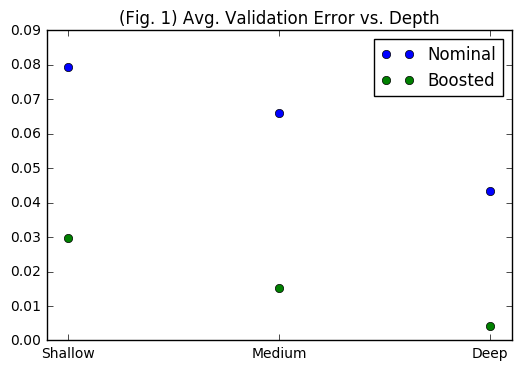

In [5]:
plt.plot(nominal_err_vs_depth, 'bo')
plt.plot(boosted_err_vs_depth, 'go')
plt.title('(Fig. 1) Avg. Validation Error vs. Depth')
plt.axis([-0.1,2.1,0.0,0.09])
plt.xticks([0, 1, 2], ['Shallow', 'Medium', 'Deep'])
plt.legend(['Nominal', 'Boosted'])
plt.show()

Above we see that greater decision tree depth improves validation error and that training with AdaBoost consistently reduces validation error. Moreover, the performance improvement over depth appears to be linear and that the linearity is preserved in going from the nominal deep model to the boosted shallow model.

In [6]:
# Get avg. validation error vs. ensemble size
nd_vs_size = nominal_results_deep.groupby('ens_size').mean()['v_err']
nm_vs_size = nominal_results_medium.groupby('ens_size').mean()['v_err']
ns_vs_size = nominal_results_shallow.groupby('ens_size').mean()['v_err']
bd_vs_size = boosted_results_deep.groupby('ens_size').mean()['v_err']
bm_vs_size = boosted_results_medium.groupby('ens_size').mean()['v_err']
bs_vs_size = boosted_results_shallow.groupby('ens_size').mean()['v_err']

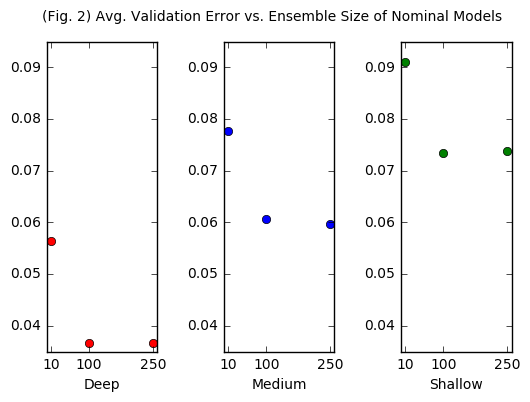

In [7]:
fig = plt.figure()

p1 = fig.add_subplot(1,3,1)
p1.set_xticks([10, 100, 250])
p1.set_xlabel('Deep')
p1.axis([0,260,0.035,0.095])
p1.plot(nd_vs_size, 'ro')

p2 = fig.add_subplot(1,3,2)
p2.set_xticks([10, 100, 250])
p2.set_xlabel('Medium')
p2.axis([0,260,0.035,0.095])
p2.plot(nm_vs_size, 'bo')

p3 = fig.add_subplot(1,3,3)
p3.set_xticks([10, 100, 250])
p3.set_xlabel('Shallow')
p3.axis([0,260,0.035,0.095])
p3.plot(ns_vs_size, 'go')

fig.subplots_adjust(hspace = 0.9, wspace = 0.6)
fig.suptitle('(Fig. 2) Avg. Validation Error vs. Ensemble Size of Nominal Models')
plt.show()

Overall there is a decrease in validation error with increase in ensemble size for nominal models. In the shallow model validation error gets worse from 100 to 250 decision trees and in the deep and medium models error doesn't improve significantly. This suggests that there is overfitting past an ensemble size of 100. For this reason all boosted models were trained on 100 decision trees and their performance vs. depth is in Fig. 1. The models used on the test set were also trained on 100 decision trees in order to avoid overfitting.

In [8]:
# Get avg. validation error vs. number of boosting iterations
bd_vs_M = boosted_results_deep.groupby('M').mean()['v_err']
bm_vs_M = boosted_results_medium.groupby('M').mean()['v_err']
bs_vs_M = boosted_results_shallow.groupby('M').mean()['v_err']

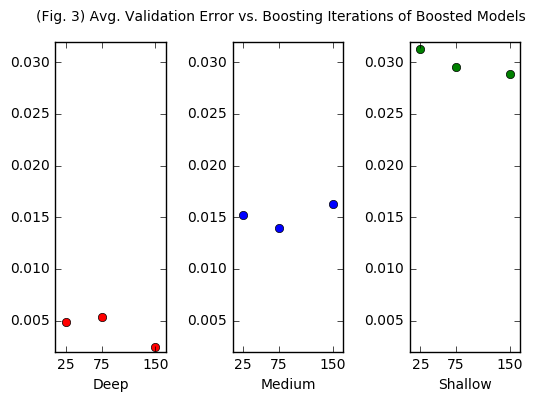

In [9]:
fig = plt.figure()

p1 = fig.add_subplot(1,3,1)
p1.set_xticks([25,75,150])
p1.set_xlabel('Deep')
p1.axis([10,165,0.002,0.032])
p1.plot(bd_vs_M, 'ro')

p2 = fig.add_subplot(1,3,2)
p2.set_xticks([25,75,150])
p2.set_xlabel('Medium')
p2.axis([10,165,0.002,0.032])
p2.plot(bm_vs_M, 'bo')

p3 = fig.add_subplot(1,3,3)
p3.set_xticks([25,75,150])
p3.set_xlabel('Shallow')
p3.axis([10,165,0.002,0.032])
p3.plot(bs_vs_M, 'go')

fig.subplots_adjust(hspace = 0.9, wspace = 0.6)
fig.suptitle('(Fig. 3) Avg. Validation Error vs. Boosting Iterations of Boosted Models')
plt.show()

On average, validation error decreases as number of boosting iterations increases. In the medium depth model however, validation error increases on average. Given the consistent performance of the deep and shallow models, this is most likely a statistical anomaly. In order to save computing time without sacrificing boosting improvement, I use 75 iterations for the boosted test set model.

In [10]:
# Get avg. validation error vs. validation folds
nd_vs_f = nominal_results_deep.groupby('f').mean()['v_err']
nm_vs_f = nominal_results_medium.groupby('f').mean()['v_err']
ns_vs_f = nominal_results_shallow.groupby('f').mean()['v_err']

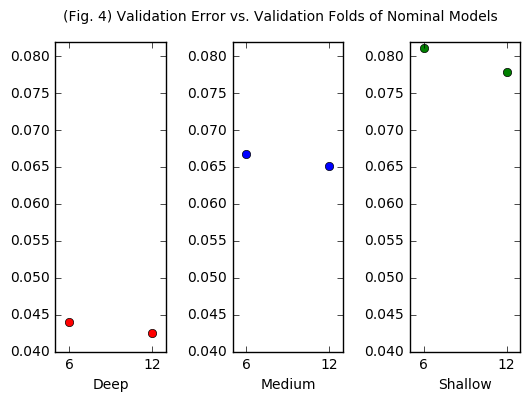

In [11]:
fig = plt.figure()

p1 = fig.add_subplot(1,3,1)
p1.set_xticks([6, 12])
p1.set_xlabel('Deep')
p1.axis([5,13,0.04,0.082])
p1.plot(nd_vs_f, 'ro')

p2 = fig.add_subplot(1,3,2)
p2.set_xticks([6, 12])
p2.set_xlabel('Medium')
p2.axis([5,13,0.04,0.082])
p2.plot(nm_vs_f, 'bo')

p3 = fig.add_subplot(1,3,3)
p3.set_xticks([6, 12])
p3.set_xlabel('Shallow')
p3.axis([5,13,0.04,0.082])
p3.plot(ns_vs_f, 'go')

fig.subplots_adjust(hspace = 0.9, wspace = 0.6)
fig.suptitle('(Fig. 4) Validation Error vs. Validation Folds of Nominal Models')
plt.show()

Validation error decreases with more folds used in cross validation simply because of more folds corresponding to larger training sets. Moreover, the variation in validation error with respect to folds is smaller than the other hyperparameters. For this reason I use only 12-fold cross validation in training boosted models to reduce computing time while training slightly stronger models. The boosted models performance vs. depth is in Fig. 1.

In [12]:
# Get avg. validation error vs. proportion of training bootstrap sample size to total training set size
nd_vs_fmf = nominal_results_deep.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)
nm_vs_fmf = nominal_results_medium.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)
ns_vs_fmf = nominal_results_shallow.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)
bd_vs_fmf = boosted_results_deep.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)
bm_vs_fmf = boosted_results_medium.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)
bs_vs_fmf = boosted_results_shallow.groupby(['f', 'mf']).mean()['v_err'].sortlevel(0, 1)

nd6 = nd_vs_fmf.unstack(level = 0)[6]
nd12 = nd_vs_fmf.unstack(level = 0)[12]
nm6 = nm_vs_fmf.unstack(level = 0)[6]
nm12 = nm_vs_fmf.unstack(level = 0)[12]
ns6 = ns_vs_fmf.unstack(level = 0)[6]
ns12 = ns_vs_fmf.unstack(level = 0)[12]
bd12 = bd_vs_fmf.unstack(level = 0)[12]
bm12 = bm_vs_fmf.unstack(level = 0)[12]
bs12 = bs_vs_fmf.unstack(level = 0)[12]

nd6.dropna(inplace = True)
nd12.dropna(inplace = True)
nm6.dropna(inplace = True)
nm12.dropna(inplace = True)
ns6.dropna(inplace = True)
ns12.dropna(inplace = True)
bd12.dropna(inplace = True)
bm12.dropna(inplace = True)
bs12.dropna(inplace = True)

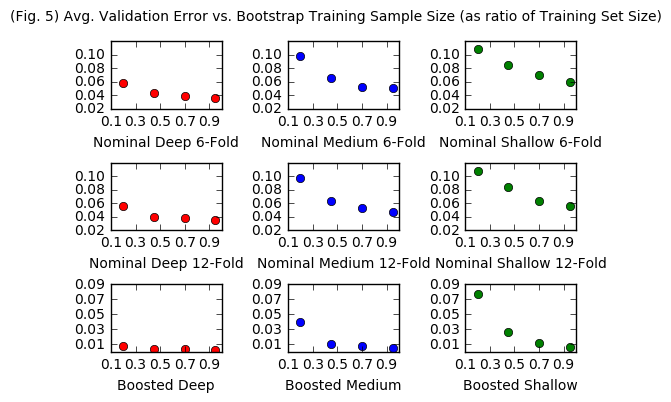

In [13]:
fig = plt.figure()

p1 = fig.add_subplot(3,3,1)
p1.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p1.set_xlabel('Nominal Deep 6-Fold')
p1.axis([0.1,1.0,0.02,0.12])
p1.plot(nd6, 'ro')

p2 = fig.add_subplot(3,3,2)
p2.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p2.set_xlabel('Nominal Medium 6-Fold')
p2.axis([0.1,1.0,0.02,0.12])
p2.plot(nm6, 'bo')

p3 = fig.add_subplot(3,3,3)
p3.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p3.set_xlabel('Nominal Shallow 6-Fold')
p3.axis([0.1,1.0,0.02,0.12])
p3.plot(ns6, 'go')

p4 = fig.add_subplot(3,3,4)
p4.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p4.set_xlabel('Nominal Deep 12-Fold')
p4.axis([0.1,1.0,0.02,0.12])
p4.plot(nd12, 'ro')

p5 = fig.add_subplot(3,3,5)
p5.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p5.set_xlabel('Nominal Medium 12-Fold')
p5.axis([0.1,1.0,0.02,0.12])
p5.plot(nm12, 'bo')

p6 = fig.add_subplot(3,3,6)
p6.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p6.set_xlabel('Nominal Shallow 12-Fold')
p6.axis([0.1,1.0,0.02,0.12])
p6.plot(ns12, 'go')

p7 = fig.add_subplot(3,3,7)
p7.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p7.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
p7.set_xlabel('Boosted Deep')
p7.axis([0.1,1.0,0,0.09])
p7.plot(bd12, 'ro')

p8 = fig.add_subplot(3,3,8)
p8.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p8.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
p8.set_xlabel('Boosted Medium')
p8.axis([0.1,1.0,0,0.09])
p8.plot(bm12, 'bo')

p9 = fig.add_subplot(3,3,9)
p9.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p9.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
p9.set_xlabel('Boosted Shallow')
p9.axis([0.1,1.0,0,0.09])
p9.plot(bs12, 'go')

fig.subplots_adjust(hspace = 0.8, wspace = 0.6)
fig.suptitle('(Fig. 5) Avg. Validation Error vs. Bootstrap Training Sample Size (as ratio of Training Set Size)')
plt.show()

The plots above give a more refined view of how folds and training set sample size affect validation error. Once again, the number of folds used doesn't affect validation error significantly. As I increase the boostrap sample size for the training set, the validation error drops noticeably. The biggest drops occur between samples 20% and 45% the size of the training set. On the test set I take a bootstrap sample 45% the size of the whole training set to take advantage of this performance increase without making training computationally cumbersome.

In [14]:
# Get avg. validation error vs. feature sample size
nd_vs_k = nominal_results_deep.groupby('k').mean()['v_err']
nm_vs_k = nominal_results_medium.groupby('k').mean()['v_err']
ns_vs_k = nominal_results_shallow.groupby('k').mean()['v_err']
bd_vs_k = boosted_results_deep.groupby('k').mean()['v_err']
bm_vs_k = boosted_results_medium.groupby('k').mean()['v_err']
bs_vs_k = boosted_results_shallow.groupby('k').mean()['v_err']

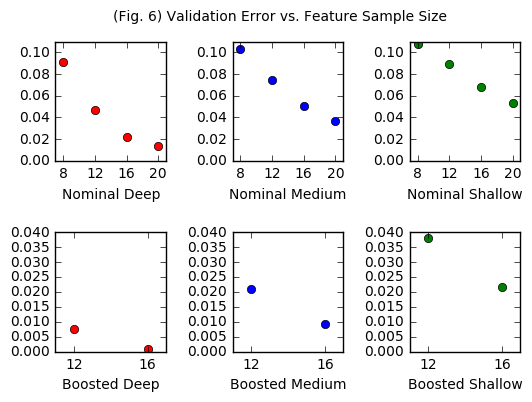

In [15]:
fig = plt.figure()

p1 = fig.add_subplot(2,3,1)
p1.set_xticks([8, 12, 16, 20])
p1.set_xlabel('Nominal Deep')
p1.axis([7,21,0,0.11])
p1.plot(nd_vs_k, 'ro')

p2 = fig.add_subplot(2,3,2)
p2.set_xticks([8, 12, 16, 20])
p2.set_xlabel('Nominal Medium')
p2.axis([7,21,0,0.11])
p2.plot(nm_vs_k, 'bo')

p3 = fig.add_subplot(2,3,3)
p3.set_xticks([8, 12, 16, 20])
p3.set_xlabel('Nominal Shallow')
p3.axis([7,21,0,0.11])
p3.plot(ns_vs_k, 'go')

p4 = fig.add_subplot(2,3,4)
p4.set_xticks([12, 16])
p4.set_xlabel('Boosted Deep')
p4.axis([11,17,0,0.04])
p4.plot(bd_vs_k, 'ro')

p5 = fig.add_subplot(2,3,5)
p5.set_xticks([12, 16])
p5.set_xlabel('Boosted Medium')
p5.axis([11,17,0,0.04])
p5.plot(bm_vs_k, 'bo')

p6 = fig.add_subplot(2,3,6)
p6.set_xticks([12, 16])
p6.set_xlabel('Boosted Shallow')
p6.axis([11,17,0,0.04])
p6.plot(bs_vs_k, 'go')

fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
fig.suptitle('(Fig. 6) Validation Error vs. Feature Sample Size')
plt.show()

In all models we see that (unsurprisingly) the more features sampled in training, the lower the validation error. Boosted models outperform nominal to the point of making depth irrelevant. That is, the boosted shallow model still outperforms the nominal deep model. In order to avoid underfitting without sacrificing computational efficiency, models on the test set use a feature sample size of 14.

In [16]:
# Get avg. validation error vs. bootstrap training sample size as a proportion stratified by number of features sampled
nd6_vs_mfk = nominal_results_deep[nominal_results_deep['f'] == 6].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
nm6_vs_mfk = nominal_results_medium[nominal_results_medium['f'] == 6].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
ns6_vs_mfk = nominal_results_shallow[nominal_results_shallow['f'] == 6].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
nd12_vs_mfk = nominal_results_deep[nominal_results_deep['f'] == 12].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
nm12_vs_mfk = nominal_results_medium[nominal_results_medium['f'] == 12].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
ns12_vs_mfk = nominal_results_shallow[nominal_results_shallow['f'] == 12].groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
bd12_vs_mfk = boosted_results_deep.groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
bm12_vs_mfk = boosted_results_medium.groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)
bs12_vs_mfk = boosted_results_shallow.groupby(['mf', 'k']).mean()['v_err'].sortlevel(0, 1).unstack(level = 1)

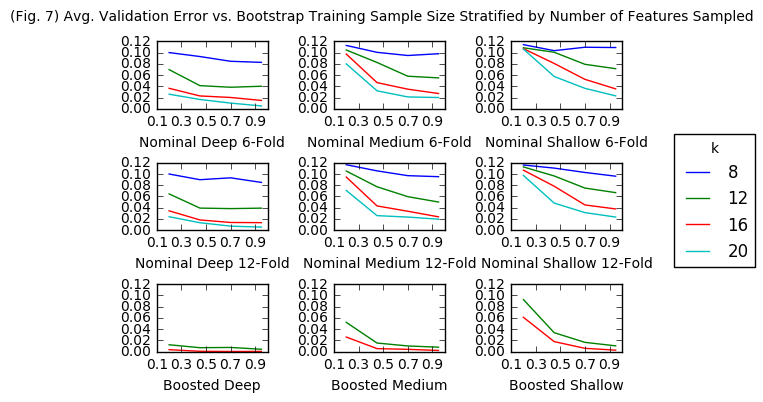

In [17]:
fig = plt.figure()

p1 = fig.add_subplot(3,3,1)
p1.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p1.set_xlabel('Nominal Deep 6-Fold')
p1.axis([0.1,1.0,0,0.12])
l1, = p1.plot(nd6_vs_mfk[8])
l2, = p1.plot(nd6_vs_mfk[12])
l3, = p1.plot(nd6_vs_mfk[16])
l4, = p1.plot(nd6_vs_mfk[20])

p2 = fig.add_subplot(3,3,2)
p2.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p2.set_xlabel('Nominal Medium 6-Fold')
p2.axis([0.1,1.0,0,0.12])
p2.plot(nm6_vs_mfk[8])
p2.plot(nm6_vs_mfk[12])
p2.plot(nm6_vs_mfk[16])
p2.plot(nm6_vs_mfk[20])

p3 = fig.add_subplot(3,3,3)
p3.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p3.set_xlabel('Nominal Shallow 6-Fold')
p3.axis([0.1,1.0,0,0.12])
p3.plot(ns6_vs_mfk[8])
p3.plot(ns6_vs_mfk[12])
p3.plot(ns6_vs_mfk[16])
p3.plot(ns6_vs_mfk[20])

p4 = fig.add_subplot(3,3,4)
p4.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p4.set_xlabel('Nominal Deep 12-Fold')
p4.axis([0.1,1.0,0,0.12])
p4.plot(nd12_vs_mfk[8])
p4.plot(nd12_vs_mfk[12])
p4.plot(nd12_vs_mfk[16])
p4.plot(nd12_vs_mfk[20])

p5 = fig.add_subplot(3,3,5)
p5.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p5.set_xlabel('Nominal Medium 12-Fold')
p5.axis([0.1,1.0,0,0.12])
p5.plot(nm12_vs_mfk[8])
p5.plot(nm12_vs_mfk[12])
p5.plot(nm12_vs_mfk[16])
p5.plot(nm12_vs_mfk[20])

p6 = fig.add_subplot(3,3,6)
p6.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p6.set_xlabel('Nominal Shallow 12-Fold')
p6.axis([0.1,1.0,0,0.12])
p6.plot(ns12_vs_mfk[8])
p6.plot(ns12_vs_mfk[12])
p6.plot(ns12_vs_mfk[16])
p6.plot(ns12_vs_mfk[20])

p7 = fig.add_subplot(3,3,7)
p7.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p7.set_xlabel('Boosted Deep')
p7.axis([0.1,1.0,0,0.12])
p7.plot(bd12_vs_mfk[12], 'g')
p7.plot(bd12_vs_mfk[16], 'r')

p8 = fig.add_subplot(3,3,8)
p8.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p8.set_xlabel('Boosted Medium')
p8.axis([0.1,1.0,0,0.12])
p8.plot(bm12_vs_mfk[12], 'g')
p8.plot(bm12_vs_mfk[16], 'r')

p9 = fig.add_subplot(3,3,9)
p9.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
p9.set_xlabel('Boosted Shallow')
p9.axis([0.1,1.0,0,0.12])
p9.plot(bs12_vs_mfk[12], 'g')
p9.plot(bs12_vs_mfk[16], 'r')

fig.legend(handles = [l1, l2, l3, l4], labels = [8, 12, 16, 20], loc = 'center right', title = 'k')
fig.subplots_adjust(hspace = 0.8, wspace = 0.6)
fig.suptitle('(Fig. 7) Avg. Validation Error vs. Bootstrap Training Sample Size Stratified by Number of Features Sampled')
plt.show()

The above figure gives a more detailed view of how increasing the training set sample size improves validation error. Shallower models that sample more features benefit more from increasing the bootstrap sample size. The deeper models and models that sample less features are more robust to training set sample size. Conversely, deeper models that sample less of the training set improve the most from increasing the number of features sampled. Shallower models that sample more of the training set are more robust to feature sample size.

In [18]:
# I estimate the validation error with k = 14 by averaging the validation errors with k = 12, 16
n_v_err_12 = nominal_results_medium[(nominal_results_medium['ens_size'] == 100) & (nominal_results_medium['f'] == 12) & 
                                    (nominal_results_medium['m'] == 3350) & (nominal_results_medium['k'] == 12)]['v_err']
n_v_err_16 = nominal_results_medium[(nominal_results_medium['ens_size'] == 100) & (nominal_results_medium['f'] == 12) & 
                                    (nominal_results_medium['m'] == 3350) & (nominal_results_medium['k'] == 16)]['v_err']
nom_v_err = (float(n_v_err_12) + float(n_v_err_16)) / 2
print('Anticipated Nominal Test Error: ', nom_v_err)

Anticipated Nominal Test Error:  0.05450685079006165


In [19]:
# I estimate the validation error with k = 14 by averaging the validation errors with k = 12, 16
b_v_err_12 = boosted_results_medium[(boosted_results_medium['M'] == 75) & (boosted_results_medium['m'] == 3350) & 
                                    (boosted_results_medium['k'] == 12)]['v_err']
b_v_err_16 = boosted_results_medium[(boosted_results_medium['M'] == 75) & (boosted_results_medium['m'] == 3350) & 
                                    (boosted_results_medium['k'] == 16)]['v_err']
bos_v_err = (float(b_v_err_12) + float(b_v_err_16)) / 2
print('Anticipated Boosted Test Error: ', bos_v_err)

Anticipated Boosted Test Error:  0.009708426426911448


In [20]:
depths = ['shallow', 'medium', 'deep']

In [21]:
# Get sensitivity of validation error to feature sample size size for each model
nominal_k_sensitivities = [get_avg_sensitivity(ns_vs_k), get_avg_sensitivity(nm_vs_k), get_avg_sensitivity(nd_vs_k)]
boosted_k_sensitivities = [get_avg_sensitivity(bs_vs_k), get_avg_sensitivity(bm_vs_k), get_avg_sensitivity(bd_vs_k)]
k_sensitivity_ratios = [y/x for x,y in zip(nominal_k_sensitivities, boosted_k_sensitivities)]

for i in range(len(k_sensitivity_ratios)):
    print('The ' + depths[i] + ' boosted model\'s average validation performance is ' + str(k_sensitivity_ratios[i])[:7] + 
          ' times as sensitive to feature sample size as the ' + depths[i] + ' nominal model\'s.')
    print(' ')

The shallow boosted model's average validation performance is 0.90034 times as sensitive to feature sample size as the shallow nominal model's.
 
The medium boosted model's average validation performance is 0.54486 times as sensitive to feature sample size as the medium nominal model's.
 
The deep boosted model's average validation performance is 0.25332 times as sensitive to feature sample size as the deep nominal model's.
 


In [22]:
# Get sensitivity of validation error to boostrap training sample size as a proportion
nominal_fmf_sensitivities = [get_avg_sensitivity(ns12), get_avg_sensitivity(nm12), get_avg_sensitivity(nd12)]
boosted_fmf_sensitivities = [get_avg_sensitivity(bs12), get_avg_sensitivity(bm12), get_avg_sensitivity(bd12)]
fmf_sensitivity_ratios = [y/x for x,y in zip(nominal_fmf_sensitivities, boosted_fmf_sensitivities)]

for i in range(len(fmf_sensitivity_ratios)):
    print('The ' + depths[i] + ' boosted model\'s 12-fold validation performance is ' + str(fmf_sensitivity_ratios[i])[:7] + 
          ' times as sensitive to training bootstrap sample size as the ' + depths[i] + ' nominal model\'s.')
    print(' ')

The shallow boosted model's 12-fold validation performance is 1.34863 times as sensitive to training bootstrap sample size as the shallow nominal model's.
 
The medium boosted model's 12-fold validation performance is 0.68717 times as sensitive to training bootstrap sample size as the medium nominal model's.
 
The deep boosted model's 12-fold validation performance is 0.27769 times as sensitive to training bootstrap sample size as the deep nominal model's.
 


In [23]:
# Get sensitivity of validation error to boostrap training sample size as a proportion
###
# The error series used to compute avg. sensitivity here is an average of the validation error vs. bootstrap training sample 
# size of models using 12 and 16 features sampled at random in order to obtain an estimate of performance of models using 14
# features (since that is what is done on the test set). This assumes linearity between error and number of features sampled
# which seems reasonable from Fig. 7.
ns12_vs_mfk_est = (ns12_vs_mfk[12] + ns12_vs_mfk[16])/2
nm12_vs_mfk_est = (nm12_vs_mfk[12] + nm12_vs_mfk[16])/2
nd12_vs_mfk_est = (nd12_vs_mfk[12] + nd12_vs_mfk[16])/2
bs12_vs_mfk_est = (bs12_vs_mfk[12] + bs12_vs_mfk[16])/2
bm12_vs_mfk_est = (bm12_vs_mfk[12] + bm12_vs_mfk[16])/2
bd12_vs_mfk_est = (bd12_vs_mfk[12] + bd12_vs_mfk[16])/2

nominal_mfk_sensitivities = [get_avg_sensitivity(ns12_vs_mfk_est), get_avg_sensitivity(nm12_vs_mfk_est), get_avg_sensitivity(nd12_vs_mfk_est)]
boosted_mfk_sensitivities = [get_avg_sensitivity(bs12_vs_mfk_est), get_avg_sensitivity(bm12_vs_mfk_est), get_avg_sensitivity(bd12_vs_mfk_est)]
mfk_sensitivity_ratios = [y/x for x,y in zip(nominal_mfk_sensitivities, boosted_mfk_sensitivities)]

for i in range(len(mfk_sensitivity_ratios)):
    print('The ' + depths[i] + ' boosted model\'s estimated 14-feature sample validation performance is ' + str(mfk_sensitivity_ratios[i])[:7] + 
          ' times as sensitive to training bootstrap sample size as the ' + depths[i] + ' nominal model\'s.')
    print(' ')

The shallow boosted model's estimated 14-feature sample validation performance is 1.22679 times as sensitive to training bootstrap sample size as the shallow nominal model's.
 
The medium boosted model's estimated 14-feature sample validation performance is 0.54105 times as sensitive to training bootstrap sample size as the medium nominal model's.
 
The deep boosted model's estimated 14-feature sample validation performance is 0.23613 times as sensitive to training bootstrap sample size as the deep nominal model's.
 


The calculations above show that as decision tree depth increases, boosted models become far more robust than nominal over a variety of hyperparameters.

## Generalization & Further Analysis

Now that we know which hyperparameters work well for the different models, we compare the test set performance of a nominal medium depth classifier and a medium iteration, medium depth boosted classifier. Each model is trained on 100 decision trees with 14 features selected by a simple random sample and 45% of the training set selected by a bootstrap sample (see the section above for how these hyperparameters were chosen). I analyze the test error, confusion matrix, and reciever-operating-characteristic curve of each model in order to infer the classifier's performance on the entire mushroom population.

In [3]:
def run_model(ens_size, k, m, boosting = False, M = None, thresh = 0):
    # Returns test error, predicted labels and true labels of (possibly boosted) random forest of size ens_size and
    # feature sample size k, training sample size m and if boosting M iterations.
    global X_train, Y_train, X_test, Y_test
    
    if boosting & (M is None):
        M = 75
    
    if boosting:
        forest = make_and_train_boosted_random_forest(X_train, Y_train, ens_size, m, k, M, 'medium')
    else:
        forest = make_and_train_random_forest(X_train, Y_train, ens_size, m, k, 'medium')
        
    return evaluate_random_forest(forest, X_test, Y_test, threshold = thresh)


In [4]:
def get_metrics(ens_size, k, m, boost = False):
    # Returns precision, recall, and false positive rate of (possibly boosted) classifier with ensemble size
    # ens_size, feature sample size k and training sample size m across full range of classification thresholds.
    
    thresholds = np.arange(-1.0, 1.0, 0.02)
    precision = []
    recall = []
    fpr = []
    for thr in thresholds:
        _, results = run_model(ens_size, k, m, boosting = boost, thresh = thr)
        y_hat, y_true = np.array(results['predicted']), np.array(results['true'])
        tru_pos = sum([1 if ((yh == 1) and (y == 1)) else 0 for yh, y in zip(y_hat, y_true)])
        fals_pos = sum([1 if ((yh == 1) and (y == -1)) else 0 for yh, y in zip(y_hat, y_true)])
        pred_pos = sum([1 if (yh == 1) else 0 for yh in y_hat])
        act_pos = sum([1 if (y == 1) else 0 for y in y_true])
        
        fpr.append(fals_pos/(len(y_true)-act_pos))
        # Cases avoid zero-division error (replaces 0/0 with 1)
        if pred_pos != 0:
            precision.append(tru_pos/pred_pos)
        elif pred_pos == 0:
            precision.append(1)
        if act_pos != 0:
            recall.append(tru_pos/act_pos)
        elif act_pos == 0:
            recall.append(1)
    return pd.DataFrame(np.array([thresholds, precision, recall, fpr]).T, columns = ['threshold', 'precision', 'recall', 'fpr'])

In [5]:
# Get nominal test (generalization) error and results here
test_error, nominal_results = run_model(100, 14, 3350, boosting = False)
nominal_results.to_csv('nominal_results.csv')
nominal_metrics = get_metrics(100, 14, 3350, boost = False)
nominal_metrics.to_csv('metrics_nominal.csv')
print('Nominal Test Error: ', test_error)

Nominal Test Error:  0.07380073800738007


In [6]:
# Get boosted test (generalization) error and results here
# WARNING: Takes a long time
test_error, boosted_results = run_model(100, 14, 3350, boosting = True)
boosted_results.to_csv('boosted_results.csv')
boosted_metrics = get_metrics(100, 14, 3350, boost = True)
boosted_metrics.to_csv('metrics_boosted.csv')
print('Boosted Test error: ', test_error)

Boosted Test error:  0.004920049200492005


In [2]:
def auc(metrics):
    # Computes area under ROC-curve of a given classifier
    met = metrics.sort_values(by = 'fpr')
    fpr = list(met['fpr'])
    recall = list(met['recall'])
    
    auc = 0
    for i in range(1,len(metrics)):
        auc = auc + (fpr[i] - fpr[i-1])*(recall[i] + recall[i-1])/2
    
    return auc

In [3]:
# Visualizations, analysis, conclusions go here

boosted_results = pd.read_csv('boosted_results.csv').iloc[:,[1,2]]
boosted_metrics = pd.read_csv('metrics_boosted.csv').iloc[:,[1,2,3,4]]
nominal_results = pd.read_csv('nominal_results.csv').iloc[:,[1,2]]
nominal_metrics = pd.read_csv('metrics_nominal.csv').iloc[:,[1,2,3,4]]

In [4]:
print('Nominal Confusion Matrix')
conf_nominal = pd.crosstab(nominal_results['predicted'], nominal_results['true'])
conf_nominal

Nominal Confusion Matrix


true,-1.0,1.0
predicted,,
-1.0,433,57
1.0,0,323


In [5]:
print('Boosted Confusion Matrix')
conf_boosted = pd.crosstab(boosted_results['predicted'], boosted_results['true'])
conf_boosted

Boosted Confusion Matrix


true,-1.0,1.0
predicted,,
-1.0,433,4
1.0,0,376


In [6]:
tpn = conf_nominal[1.0][1.0]
fpn = conf_nominal[-1.0][1.0]
tnn = conf_nominal[-1.0][-1.0]
fnn = conf_nominal[1.0][-1.0]

tpb = conf_boosted[1.0][1.0]
fpb = conf_boosted[-1.0][1.0]
tnb = conf_boosted[-1.0][-1.0]
fnb = conf_boosted[1.0][-1.0]

recall_nominal = tpn / (tpn + fnn)
fpr_nominal = fpn / (fpn + tnn)
precision_nominal = tpn / (tpn + fpn)
for_nominal = fnn / (fnn + tnn)
f1_nominal = 2*precision_nominal*recall_nominal / (precision_nominal + recall_nominal)
mcc_nominal = (tpn*tnn - fpn*fnn)/np.sqrt((tpn+fpn)*(tpn+fnn)*(tnn+fpn)*(tnn+fnn))

recall_boosted = tpb / (tpb + fnb)
fpr_boosted = fpb / (fpb + tnb)
precision_boosted = tpb / (tpb + fpb)
for_boosted = fnb / (fnb + tnb)
f1_boosted = 2*precision_boosted*recall_boosted / (precision_boosted + recall_boosted)
mcc_boosted = (tpb*tnb - fpb*fnb)/np.sqrt((tpb+fpb)*(tpb+fnb)*(tnb+fpb)*(tnb+fnb))

print('Nominal Recall: ', recall_nominal)
print('Nominal False Positive Rate: ', fpr_nominal)
print('Nominal Precision: ', precision_nominal)
print('Nominal False Omission Rate: ', for_nominal)
print('Nominal Matthew\'s Correlation Coefficient: ', mcc_nominal)
print(' ')
print('Boosted Recall: ', recall_boosted)
print('Boosted False Positive Rate: ', fpr_boosted)
print('Boosted Precision: ', precision_boosted)
print('Boosted False Omission Rate: ', for_boosted)
print('Boosted Matthew\'s Correlation Coefficient: ', mcc_boosted)

Nominal Recall:  0.85
Nominal False Positive Rate:  0.0
Nominal Precision:  1.0
Nominal False Omission Rate:  0.11632653061224489
Nominal Matthew's Correlation Coefficient:  0.8666732077199525
 
Boosted Recall:  0.9894736842105263
Boosted False Positive Rate:  0.0
Boosted Precision:  1.0
Boosted False Omission Rate:  0.009153318077803204
Boosted Matthew's Correlation Coefficient:  0.9901599450842938


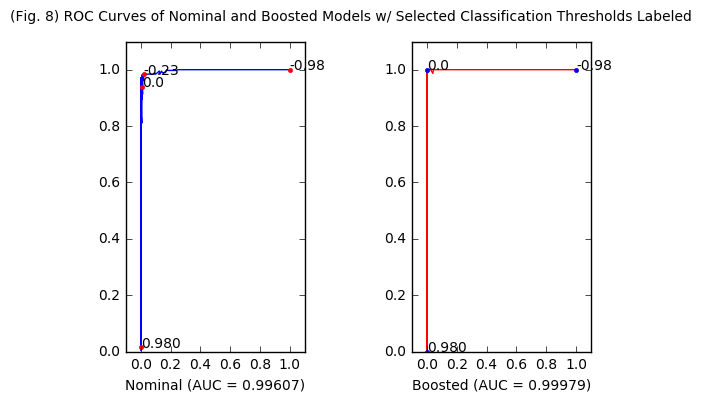

In [7]:
fig = plt.figure()

n_threshs = nominal_metrics.iloc[[1, 38, 50, 99]][['threshold', 'recall', 'fpr']]
b_threshs = boosted_metrics.iloc[[1, 50, 99]][['threshold', 'recall', 'fpr']]

nom_met = nominal_metrics.sort_values(by = 'fpr')
bos_met = boosted_metrics.sort_values(by = 'fpr')

boosted_auc, nominal_auc = auc(boosted_metrics), auc(nominal_metrics)

p1 = fig.add_subplot(1,2,1)
p1.axis([-0.1,1.1,0,1.1])
p1.set_xlabel('Nominal (AUC = ' + str(nominal_auc)[:7] +')')
p1.plot(nom_met['fpr'], nom_met['recall'])
p1.plot(n_threshs['fpr'], n_threshs['recall'], 'r.')
for i, lbl in enumerate(n_threshs['threshold']):
    p1.annotate(str(lbl)[:5], (n_threshs['fpr'].iloc[i], n_threshs['recall'].iloc[i]))

p2 = fig.add_subplot(1,2,2)
p2.axis([-0.1,1.1,0,1.1])
p2.set_xlabel('Boosted (AUC = ' + str(boosted_auc)[:7] + ')')
p2.plot(bos_met['fpr'], bos_met['recall'], 'r')
p2.plot(b_threshs['fpr'], b_threshs['recall'], 'b.')
for i, lbl in enumerate(b_threshs['threshold']):
    p2.annotate(str(lbl)[:5], (b_threshs['fpr'].iloc[i], b_threshs['recall'].iloc[i]))

fig.subplots_adjust(hspace = 0.0, wspace = 0.6)
fig.suptitle('(Fig. 8) ROC Curves of Nominal and Boosted Models w/ Selected Classification Thresholds Labeled')
plt.show()

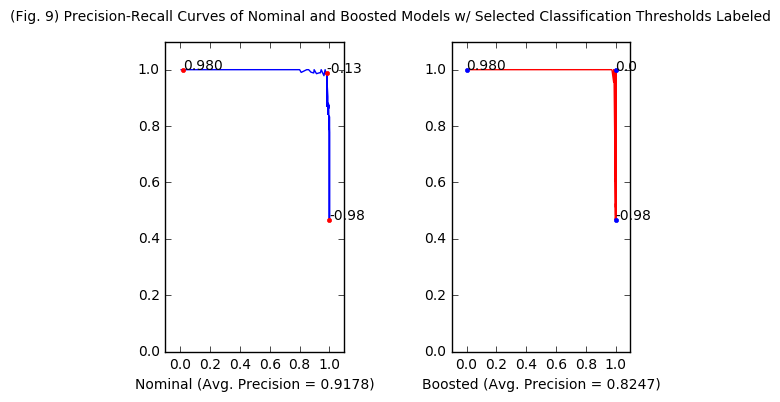

In [8]:
fig = plt.figure()

n_threshs = nominal_metrics.iloc[[1, 43, 99]][['threshold', 'precision', 'recall']]
b_threshs = boosted_metrics.iloc[[1, 50, 99]][['threshold', 'precision', 'recall']]

nom_met = nominal_metrics.sort_values(by = 'recall')
bos_met = boosted_metrics.sort_values(by = 'recall')

p1 = fig.add_subplot(1,2,1)
p1.axis([-0.1,1.1,0,1.1])
p1.set_xlabel('Nominal (Avg. Precision = ' + str(nom_met['precision'].mean())[:6] + ')')
p1.plot(nom_met['recall'], nom_met['precision'])
p1.plot(n_threshs['recall'], n_threshs['precision'], 'r.')
for i, lbl in enumerate(n_threshs['threshold']):
    p1.annotate(str(lbl)[:5], (n_threshs['recall'].iloc[i], n_threshs['precision'].iloc[i]))

p2 = fig.add_subplot(1,2,2)
p2.axis([-0.1,1.1,0,1.1])
p2.set_xlabel('Boosted (Avg. Precision = ' + str(bos_met['precision'].mean())[:6] + ')')
p2.plot(bos_met['recall'], bos_met['precision'], 'r')
p2.plot(b_threshs['recall'], b_threshs['precision'], 'b.')
for i, lbl in enumerate(b_threshs['threshold']):
    p2.annotate(str(lbl)[:5], (b_threshs['recall'].iloc[i], b_threshs['precision'].iloc[i]))

fig.subplots_adjust(hspace = 0.0, wspace = 0.6)
fig.suptitle('(Fig. 9) Precision-Recall Curves of Nominal and Boosted Models w/ Selected Classification Thresholds Labeled')
plt.show()

Both models perform quite well on the test set with comparable anticipated and actual test errors respectively. The boosted model's test error is negligible compared to that of the nominal. 

At the baseline classification threshold (0.0) each model has a false positive rate of zero which translates to perfect precision respectively. This means the classifier does not mark edible mushrooms as poisonous regardless of boosting.
Boosting increases recall however which makes the classifier much safer. This is because as recall improves, the rate of poisonous mushrooms marked as edible vanishes. The boosted model's recall is nearly perfect whereas the nominal model classifies 15% of poisonous mushrooms as edible. Consequently, boosting improves the classifier's false omission rate by over one order of magnitude. This means the boosted model incorrectly identifies edible mushrooms about 10 times less frequently than the boosted model. Lastly, boosting improves the classifier's Matthew's Correlation Coefficient. This metric is more robust to class-imbalance than the aforementioned confusion-matrix derivations so its improvement suggests that boosted models generalize better to class-imbalanced populations as well.

In considering all classification thresholds (-1 to 1) both nominal and boosted models yield excellent ROC and Precision-Recall curves. None of the plots in figures 8 or 9 display any significant tradeoff between recall and false-positive-rate or precision and recall respectively as classification threshold varies. Boosting's main use here is in eliminating bias. That is, for nominal models the classification thresholds that yield optimal tradeoff (closest to (0,1) for ROC and closest to (1,1) for precision-recall) are offset from the baseline classification threshold. A threshold of -0.23 is closer to optimal than baseline for nominal ROC performance and a threshold of -0.13 is closer for nominal precision-recall performance. Boosting in both contexts moves the baseline threshold to (0,1) and (1,1) respectively, effectively eliminating threshold bias.

To summarize, the nominal model performs decently on the test set but boosting improves the performance to the point of the classifier being (arguably) safe to use, robust to class imbalance and optimally performing with the standard classification threshold.

## Summary

In this project I implement a random forest classifier on a dataset where each entry contains categorical information about a
unique mushroom and a class label marking it as poisonous or edible. I train models using both standard sklearn libraries and AdaBoost on ensembles of deep, medium and shallow decision trees yielding a total of 6 models to analyze. The hyperparameters of the models are ensemble size, number of folds in cross-validation, training set bootstrap sample size, feature sample size and for boosted models number of boosting iterations. Once trained, I analyze the validation performance of these 6 models over the hyperparameter search space in order to choose models and hyperparameters to use on the test set. In training, the main improvement in boosting is in making validation error more robust to variations in hyperparameters.

For the test set, I analyze the performance of nominal and boosted models trained on 100 medium depth decision trees where each decision tree takes a simple random sample of 14 (out of 22 total) features from a bootstrap sample of 3350 (out of 7312 total) training points. The boosted models used 75 iterations of AdaBoost in training. In analysis of the test set, we see that using AdaBoost increases recall (making the classifier much safer to use in practice), eliminates bias from the predictions and makes predictions more robust to class-imbalanced populations.

